In [300]:
%matplotlib inline
from pandas import Series
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import random
from shapely.geometry import Point
import numpy as np
import geopandas as gpd
random.seed(35)

In [301]:
# on utilise la base de données des taxi dispo sur le site de NYC
data = 'C:/Users/Adrien/Desktop/bertille/Python projet/Python/yellow_tripdata_2016-06.csv'
df0 = pd.read_csv(data, sep=',')
df0 = df0[(df0['pickup_longitude'] < -73.7) & (df0['pickup_longitude'] > -74.1) & (df0['pickup_latitude'] > 40.4) & (df0['pickup_latitude'] < 51)]
df0=df0.where(df0.tip_amount.notna())
df0 = df0[df0.payment_type==1]
# si on veut on peut prendre un echantillon : df = df0.sample(100).reset_index()

# Introduction : apperçu des données
Nous disposons des données sur les tips par carte bancaire sur le mois de juin 2016. Après avoir récupéré dans la base principale les données concernant les paiements par carte bancaire et les observations respectant certaines conditions (nous éliminons notamment les individus qui sortent de la zone), il nous reste 7227844 observations Nous allons créer une série temporelle des moyennes par demi-heure des tips au cours du mois. Nous allons ensuite étudier cette série temporelle.

In [302]:
print(df0.shape)
df0.head()

(7227844, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0.0,0.3,27.30
2,2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.0,0.5,0.5,1.00,0.0,0.3,28.30
4,2,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1,N,-73.985909,40.766445,1,13.5,0.5,0.5,2.96,0.0,0.3,17.76
5,2,2016-06-09 21:06:36,2016-06-09 21:19:21,1,2.17,-73.995201,40.739491,1,N,-73.993202,40.762642,1,10.5,0.5,0.5,2.36,0.0,0.3,14.16


On crée une variable X_d_t où X_d_t = la médiane des tips newyorkais entre la demi-heure t-1 et la demi-heure t au jour d. Nous avons choisi de travailler sur la médiane plutôt que sur la moyenne. En effet, la moyenne donne des résultats assez proches, mais avec beaucoup de variabilité. Nous préférons donc utiliser la médiane, moins sensible à la présence de valeurs extrêmes dans l'heure. Voici à quoi ressemblent nos données après cette calcul des médianes par demi-heure :

In [303]:
ts = df0[['tpep_dropoff_datetime', 'tip_amount']].set_index('tpep_dropoff_datetime')
ts.index = pd.to_datetime(ts.index)
ts = ts[(ts.index >= '2016-06-01') & (ts.index < '2016-06-30')]
ts_hourly = ts.resample('H').mean()
ts_hourly.head()

,tip_amount
tpep_dropoff_datetime,
2016-06-01 00:00:00,2.741030
2016-06-01 01:00:00,2.981748
2016-06-01 02:00:00,2.657042
2016-06-01 03:00:00,2.755595
2016-06-01 04:00:00,3.530284


Visualisons ces données. On peut remarquer sur le graphique suivant une période d'un jour. Nous pouvons regarder de plus près ce qui se passe chaque jour pour voir ce qui marque le début de cette période.

#### Sur le mois

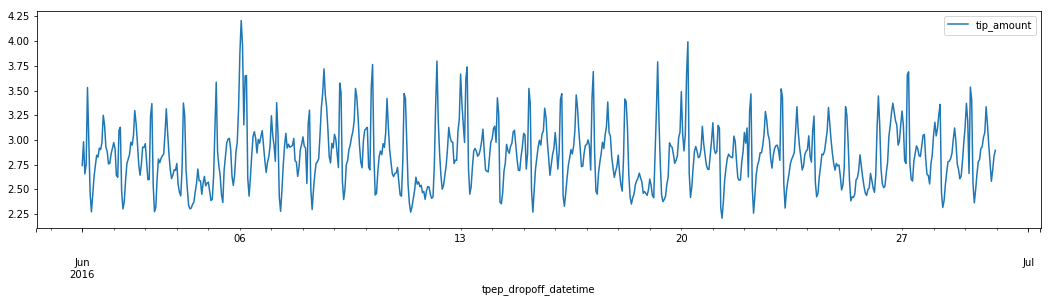

In [304]:
ts_hourly.plot(figsize=(18,4))

#### En semaine
Comme on peut le voir sur ces graphiques, il est fréquent d'observer une chute des pourboires la nuit

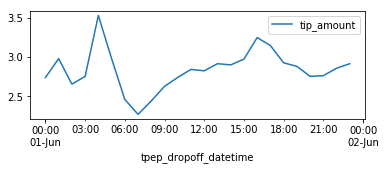

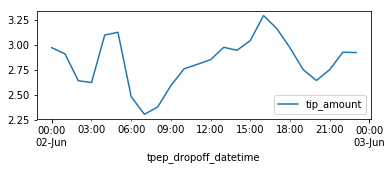

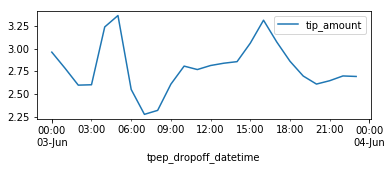

In [305]:
ts_hourly['2016-06-01'].plot(figsize=(6,2))
ts_hourly['2016-06-02'].plot(figsize=(6,2))
ts_hourly['2016-06-03'].plot(figsize=(6,2))

#### Le samedi
Cependant, regardons ce que l'on observe chaque samedi :

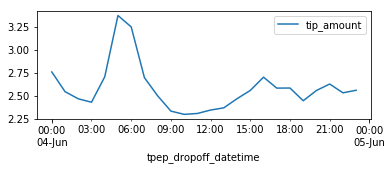

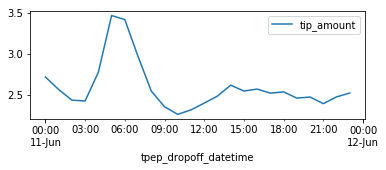

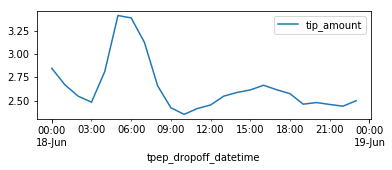

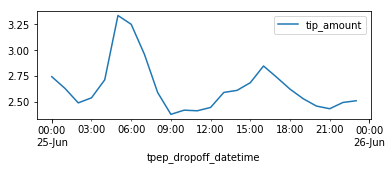

In [306]:
ts_hourly['2016-06-04'].plot(figsize=(6,2))
ts_hourly['2016-06-11'].plot(figsize=(6,2))
ts_hourly['2016-06-18'].plot(figsize=(6,2))
ts_hourly['2016-06-25'].plot(figsize=(6,2))

#### Le dimanche
Le dimanche, on a également des valeurs moyennes dans la nuit, une chute le matin à partir de 9h et une hausse en soirée.

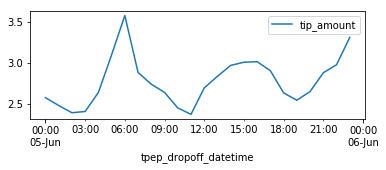

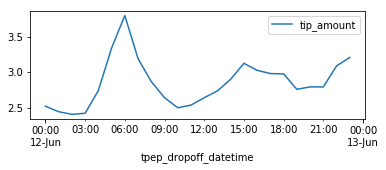

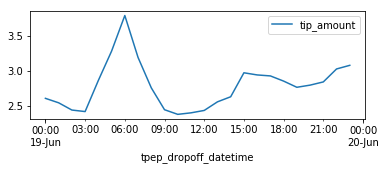

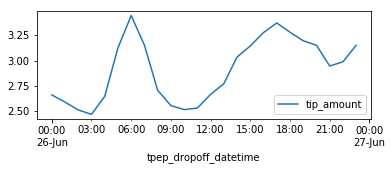

In [307]:
ts_hourly['2016-06-05'].plot(figsize=(6,2))
ts_hourly['2016-06-12'].plot(figsize=(6,2))
ts_hourly['2016-06-19'].plot(figsize=(6,2))
ts_hourly['2016-06-26'].plot(figsize=(6,2))

# Décomposition de la série en une tendance, une saisonnalité, un bruit

Dans tous les cas, on travail sur le log de la série pour diminuer l'hétéroscédasticité. Premier essai : on utilise la commande seasonal_decompose sans préciser de fréquence :

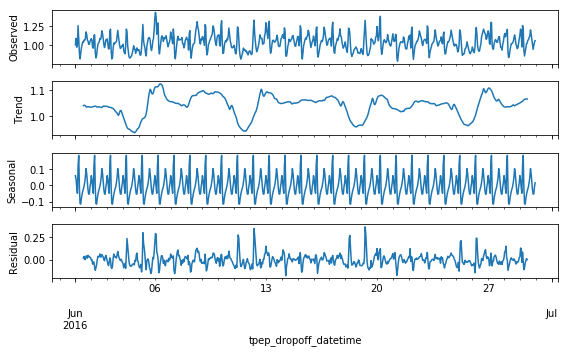

In [308]:
# Le choix du modèle, additif ou multiplicatif, importe peu 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition0 = seasonal_decompose(np.log(ts_hourly), model='additive')
decomposition0.plot()
plt.show()

Comme nous pouvons le constater, en laissant à la commande seasonal_decompose la choix de la fréquence, on obtient une tendance un peu particulière. Ses cycles ne semblent pas aléatoires, ils correspondent plutôt à des intervalles d'une semaine. Pour corriger ce problème, on préfèrera spécifier nous même la fréquence pour la décomposition de la série :

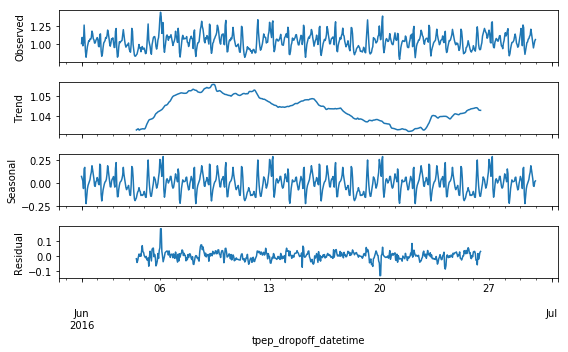

In [309]:
decomposition = seasonal_decompose(np.log(ts_hourly), model='additive',freq=7*24)
decomposition.plot()
plt.show()

On va donc conserver les résidus de cette seconde décomposition. Notons que l'on a testé les deux à l'aide du test qui suit, que les deux séries de résidus donnent une p-value très faible, mais qu'elle est nettement plus faible pour la deuxième décomposition. Il n'y a donc pas de raisons de préférer la première.

In [310]:
#Remarque : il est aussi possible de rendre la série plus stationnaire par des commandes du type :
#differentiated_ts_hourly=(ts_hourly).shift(periods=24)
#differentiated_ts_hourly=differentiated_ts_hourly.dropna()
#Cela dit, Comme nous allons le voir, la p-value du test de stationarité des résidus est déjà encourageante. La différentiation
#nous faisant perdre quelques observations sans grandes améliorations, nous décidons d'en rester à la décomposition ci-dessus.

Les graphiques ci-dessus nous confortent dans l'idée que les données suivent une période d'une semaine et une période de 24 heures. La forme de la tendance n'est pas surprenante au vu de ce que l'on a observé précédemment. Nous observons en effet des périodes d'une semaine, avec une baisse au moment du weekend (le premier juin est un mercredi, les valeurs chutent pour la première fois entre vendredi après-midi et dimanche soir).

# Mise en place d'un modèle ARMA

## Stationarité de la série

Tant que la série n'est pas stationnaire, nous ne pouvons pas mettre en place notre modèle de série temporelle. Nous vérifions la stationnarité de notre série (la série originale et la série des résidus). Pour savoir si une série est stationnaire, on peut faire un test de Dickey Fuller.

In [311]:
# série non décomposée
from pandas import Series
from statsmodels.tsa.stattools import adfuller
X = np.log(ts_hourly)['tip_amount']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %.ef' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.074966
p-value: 2e-05f
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [312]:
# série des résidus
from pandas import Series
from statsmodels.tsa.stattools import adfuller
X = decomposition.resid.dropna()['tip_amount']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %.ef' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.154532
p-value: 2e-22f
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


La p-value est très faible, ce qui nous encourage à penser que la série est stationnaire. Le rejet de l'hypothèse nulle signifie que le processus n'a pas de racine unitaire. Il revient à rejeter la non-stationnarité, ce qui nous permet de penser que la série temporelle est stationnaire. La p-value pour la série des résidus est nettement plus faible que la p-value de la série non décomposée, on préfère donc travailler sur la série des résidus

## Choix des ordres p et q

Notes pour l'interprétation des graphiques :

###### L'autocorrélogramme
Nous donne les coefficients de corrélation :
- entre la variable X_t et la variable X_(t-1)
- entre la variable X_t et la variable X_(t-2)
- etc.

De l'autocorrélogramme, nous tirons une idée de l'ordre maximal à tester pour la partie MA de notre modèle

###### L'autocorrélogramme partiel
Nous donne les coefficients d'autocorrélation :
- entre la variable X_t et la variable X_(t-1)
- entre la variable X_t et la variable X_(t-2) sans l'influence de la variable X_(t-1)
- entre la variable X_t et la variable X_(t-2) sans l'influence des variables X_(t-1) et X_(t-2)
- etc.

De l'autocorrélogramme partiel, nous tirons une idée de l'ordre maximal à tester pour la partie AR de notre modèle


###### En bleu : l'intervalle de confiance
Certains coefficients sortent de l'intervalle de confiance. Cela indique qu'il y a un problème d'autocorrélation dans la série

Générons ces graphiques :

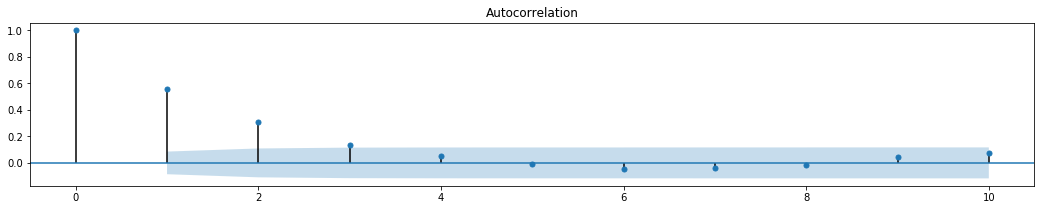

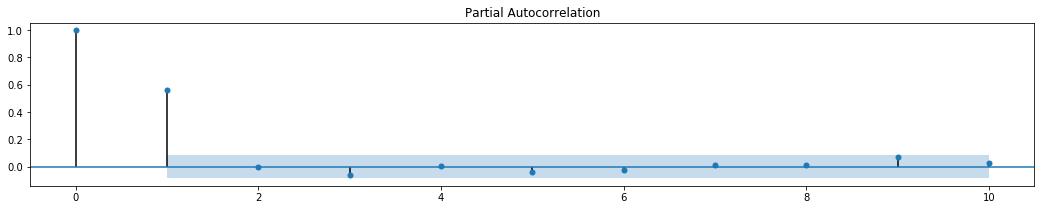

In [313]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 3
plt.rcParams["figure.figsize"] = fig_size
fig = plt.figure()
ax1 = fig.add_subplot()
fig = plot_acf(decomposition.resid.dropna(), lags=10, ax=ax1)
ax2 = fig.add_subplot()
fig = plot_pacf(decomposition.resid.dropna(), lags=10, ax=ax2)
plt.show()

Que tirer de ces graphs ? Nous avons représentés l'autocorrélation pour la même série temporelle (les tips heure par heure). Nous voyons une forte corrélation entre X_t et X_(t-1), X_t et X_(t-2), X_t et X_(t-3) (ACF). Il semblerait que l'ordre maximal à tester pour la partie MA soit 3 et l'ordre maximal à tester pour la partie AR soit 1. On pourrait avoir un doute pour l'ordre 3 pour Pmax, c'est pourquoi on va regarder les modèles jusqu'aux ordres 3 pour p et q. (Remarque : si on regarde les corrélations avec plus de lags, on n'a pas complètement fait disparaître la corrélation entre X_t et X_(t+168(une semaine)) mais elle est très faible. On la néglige ici du fait de sa faiblesse relative et de la puissance de calcul nécessaire mais on pourrait sur cette base tester d'autres ordres pour notre AR et notre MA).

### Critères de sélection de nos ordres : AIC et BIC

In [314]:
Qmax = 3
Pmax = 1
tseries = decomposition.resid.dropna()
a = pd.DataFrame(index=range(Pmax+1), columns=range(Qmax+1))
a.index.names = ['P']
a.columns.names = ['Q']

from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
import numpy as np

res = sm.tsa.arma_order_select_ic(tseries, max_ar=Pmax, max_ma=Qmax, ic=['aic', 'bic'], trend='nc')

In [315]:
res.aic

,0,1,2,3
0,NaN,-2397.928245,-2440.367088,-2444.107772
1,-2448.789158,-2446.789304,-2446.531343,-2444.556759


In [316]:
res.bic

,0,1,2,3
0,NaN,-2389.390053,-2427.559799,-2427.031387
1,-2440.250966,-2433.982015,-2429.454957,-2423.211277


In [317]:
print(res.aic_min_order)
print(res.bic_min_order)

(1, 0)
(1, 0)


Les deux critères font ressortir l'AR(1), ce qui n'est pas particulièrement conforme à notre première intuition à la vue des autocorrélogrammes. Pour ne pas écarter des modèles intéressants, nous avons présenté l'ensemble des résultats. Pour le critère AIC, les modèles avec un AR(1) donnent des résultats proches. Le modèle MA(3) aussi. Concernant le critère BIC, les modèles AR(1), ARMA(1,1) et ARMA(1,2) sont les plus proches. Nous testerons donc ces trois modèles car ils croisent les deux critères et nos conclusions sur les autocorrélogrammes.

- Modele 1 : AR(1)
- Modele 2 : ARMA(1,1)
- Modele 3 : ARMA(1,2)

In [322]:
from statsmodels.tsa.arima_model import ARMA
modele1 = ARMA(tseries, (1, 0)).fit()
modele2 = ARMA(tseries, (1, 1)).fit()
modele3 = ARMA(tseries, (1, 2)).fit()

In [323]:
print('Résultats modèle 1 :')
print(modele1.summary().tables[1])
print("")
print('Résultats modèle 2 :')
print(modele2.summary().tables[1])
print("")
print('Résultats modèle 3 :')
print(modele3.summary().tables[1])

Résultats modèle 1 :
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0009      0.002      0.404      0.687      -0.004       0.006
ar.L1.tip_amount     0.5597      0.036     15.528      0.000       0.489       0.630

Résultats modèle 2 :
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0009      0.002      0.404      0.687      -0.004       0.006
ar.L1.tip_amount     0.5599      0.060      9.266      0.000       0.441       0.678
ma.L1.tip_amount    -0.0004      0.071     -0.005      0.996      -0.139       0.138

Résultats modèle 3 :
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


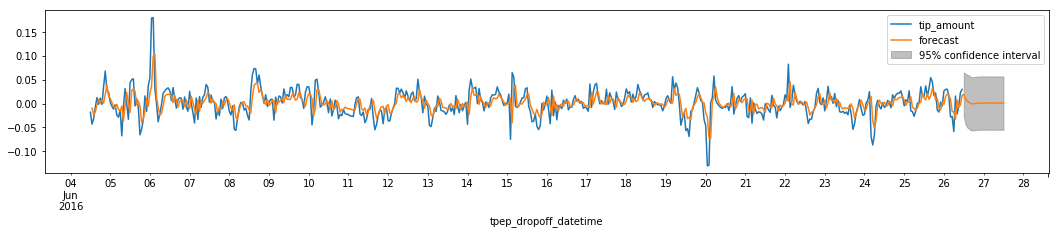

In [320]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots()
ax = tseries.loc['2016-06-04 12:00:00':].plot(ax=ax)
fig = modele1.plot_predict('2016-06-04 13:00:00', '2016-06-27 12:00:00', ax=ax, plot_insample=False)
plt.show()

Voici ce que l'on obtient avec l'AR appliqué à notre jeu de données. L'AR(1) ayant un coefficient de 0.6, il converge assez rapidement vers une moyenne (au bout de quelques heures). L'intervalle de confiance pour la prédiction est assez large. On voit que le modèle AR(1) explique mal les hauts pics. Maintenant que nous avons une prédiction pour les résidus en moyenne nuls et avec une faible variance, nous pouvons expliquer une grande partie des fluctuations avec la tendance et la saisonnalité en y ajoutant l'AR(1) de coefficient 0.5597 et de moyenne nulle.

In [383]:
predict=Series(modele1.predict(start='2016-06-04 13:00:00', end='2016-06-26 12:00:00'))
predict.index=tseries.index
predict_tot=(predict.loc[decomposition.trend['tip_amount'].notna()]+decomposition.seasonal.loc[decomposition.trend['tip_amount'].notna()])
predict_tot

tpep_dropoff_datetime
2016-06-04 12:00:00   -0.009838
2016-06-04 13:00:00   -0.023827
2016-06-04 14:00:00   -0.017123
2016-06-04 15:00:00   -0.003687
2016-06-04 16:00:00    0.007412
Freq: H, dtype: float64

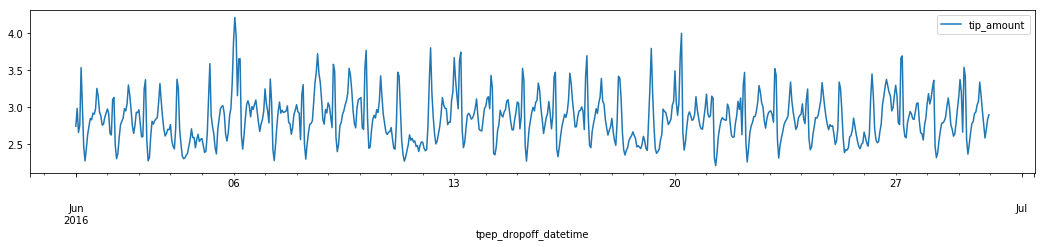

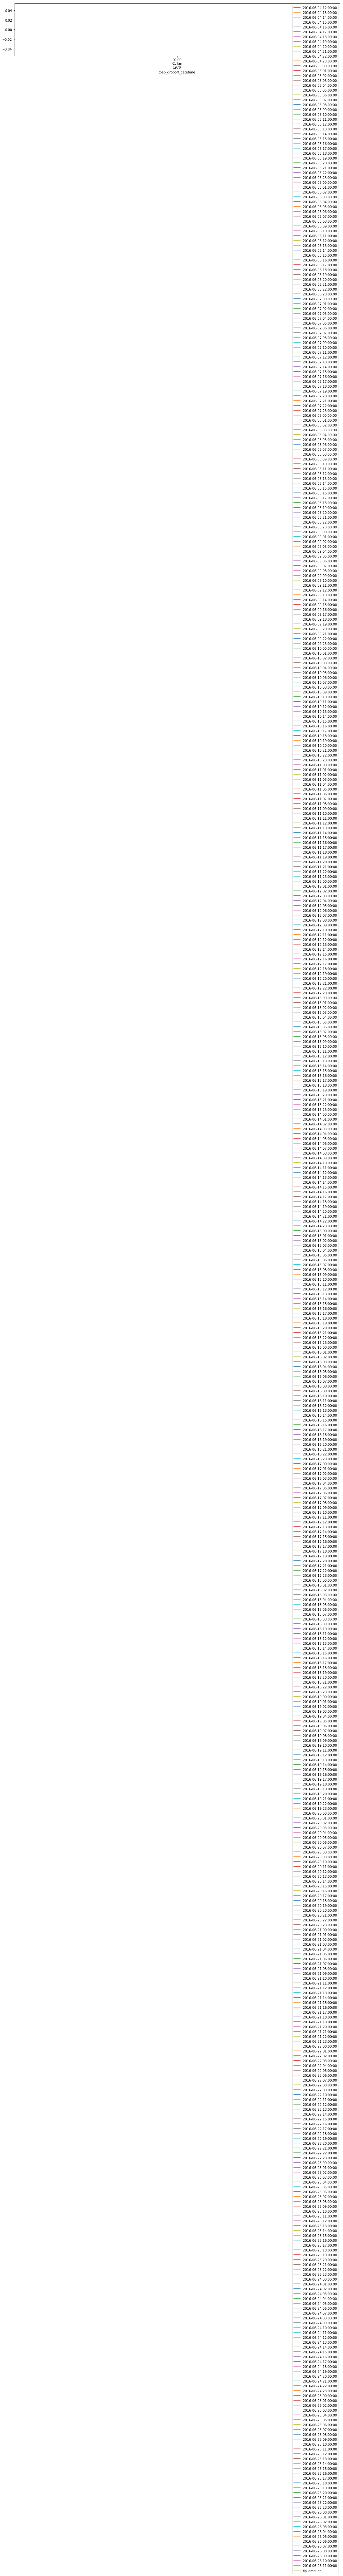

In [381]:
fig, ax = plt.subplots()
ax = ts_hourly.plot(ax=ax)
fig = predict_tot.plot()
plt.show()

In [368]:
decomposition.trend

,tip_amount
tpep_dropoff_datetime,
2016-06-01 00:00:00,NaN
2016-06-01 01:00:00,NaN
2016-06-01 02:00:00,NaN
2016-06-01 03:00:00,NaN
2016-06-01 04:00:00,NaN
2016-06-01 05:00:00,NaN
2016-06-01 06:00:00,NaN
2016-06-01 07:00:00,NaN
2016-06-01 08:00:00,NaN


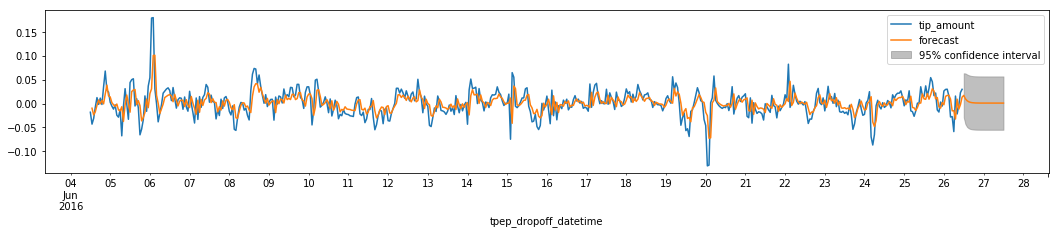

In [278]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots()
ax = tseries.loc['2016-06-04 12:00:00':].plot(ax=ax)
fig = modele2.plot_predict(start='2016-06-04 13:00:00', end='2016-06-27 12:00:00', ax=ax, plot_insample=False)
plt.show()

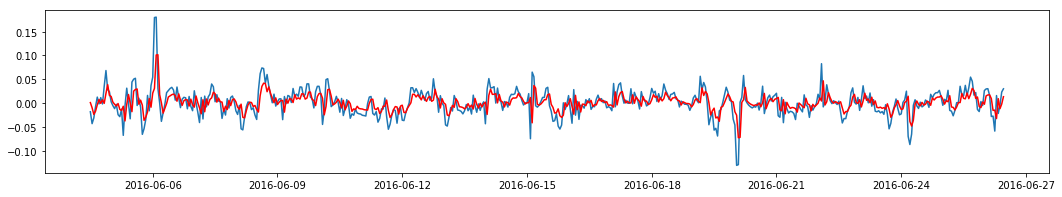

In [201]:
model = ARIMA(tseries, order=(1, 0, 1))  
results_ARIMA = model.fit(disp=-24)  
plt.plot(tseries)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [184]:
from statsmodels.tsa.arima_model import ARIMA
# ARIMA (p,0,q) = ARMA(p,q)
modele1 = ARIMA(tseries, (1, 0, 0)).fit()
modele2 = ARIMA(tseries, (1, 0, 1)).fit()
modele3 = ARIMA(tseries, (1, 0, 2)).fit()

In [185]:
print('Résultats modèle 1 :')
print(modele1.summary().tables[1])
print("")
print('Résultats modèle 2 :')
print(modele2.summary().tables[1])
print("")
print('Résultats modèle 3 :')
print(modele3.summary().tables[1])

Résultats modèle 1 :
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0009      0.002      0.404      0.687      -0.004       0.006
ar.L1.tip_amount     0.5597      0.036     15.528      0.000       0.489       0.630

Résultats modèle 2 :
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0009      0.002      0.404      0.687      -0.004       0.006
ar.L1.tip_amount     0.5599      0.060      9.266      0.000       0.441       0.678
ma.L1.tip_amount    -0.0004      0.071     -0.005      0.996      -0.139       0.138

Résultats modèle 3 :
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


In [187]:
pred = modele1.predict(start=pd.to_datetime('2016-06-04 12:00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = tseries['2016-06-04 12:00:00':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()


AttributeError: 'Series' object has no attribute 'conf_int'

In [205]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

X = tseries
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [223]:
modele2.predict()[1]

-0.009838020212205062

In [239]:
modele1.forecast(tseries.tip_amount.loc['2016-06-04 12:00:00':'2016-06-04 16:00:00'])

Exception: Data must be 1-dimensional

In [243]:
tseries.tip_amount['2016-06-04 12:00:00':'2016-06-04 16:00:00']


tpep_dropoff_datetime
2016-06-04 12:00:00   -0.018321
2016-06-04 13:00:00   -0.043316
2016-06-04 14:00:00   -0.031337
2016-06-04 15:00:00   -0.007330
2016-06-04 16:00:00    0.012501
Freq: H, Name: tip_amount, dtype: float64

In [256]:
donnees=pd.DataFrame()
donnees['realdata']=tseries['tip_amount']
donnees['forecast'] = modele1.predict(start = '2016-06-05 12:00:00', end= '2016-06-26 11:00:00', dynamic= True)  
donnees[['realdata', 'forecast']].plot(figsize=(12, 8))

TypeError: predict() got an unexpected keyword argument 'steps'

In [273]:
tseries_X=tseries[:264]
tseries_Y=tseries[264:]
yhat=modele1.forecast(steps=264)[0]
pd.Series(yhat)

0      0.017155
1      0.010017
2      0.006022
3      0.003786
4      0.002534
5      0.001834
6      0.001442
7      0.001222
8      0.001100
9      0.001031
10     0.000992
11     0.000971
12     0.000959
13     0.000952
14     0.000948
15     0.000946
16     0.000945
17     0.000944
18     0.000944
19     0.000944
20     0.000944
21     0.000944
22     0.000944
23     0.000944
24     0.000944
25     0.000944
26     0.000944
27     0.000944
28     0.000944
29     0.000944
         ...   
234    0.000944
235    0.000944
236    0.000944
237    0.000944
238    0.000944
239    0.000944
240    0.000944
241    0.000944
242    0.000944
243    0.000944
244    0.000944
245    0.000944
246    0.000944
247    0.000944
248    0.000944
249    0.000944
250    0.000944
251    0.000944
252    0.000944
253    0.000944
254    0.000944
255    0.000944
256    0.000944
257    0.000944
258    0.000944
259    0.000944
260    0.000944
261    0.000944
262    0.000944
263    0.000944
Length: 264, dtype: floa

In [270]:
tseries_X.tail()

,tip_amount
tpep_dropoff_datetime,
2016-06-15 07:00:00,-0.004563
2016-06-15 08:00:00,0.002822
2016-06-15 09:00:00,0.011699
2016-06-15 10:00:00,0.011829
2016-06-15 11:00:00,0.030911


In [275]:
tseries_Y.head()

,tip_amount
tpep_dropoff_datetime,
2016-06-15 12:00:00,0.033172
2016-06-15 13:00:00,-0.005773
2016-06-15 14:00:00,-0.017058
2016-06-15 15:00:00,-0.038525
2016-06-15 16:00:00,-0.037013


In [277]:
Series(modele1.forecast(steps=264)[0])

0      0.017155
1      0.010017
2      0.006022
3      0.003786
4      0.002534
5      0.001834
6      0.001442
7      0.001222
8      0.001100
9      0.001031
10     0.000992
11     0.000971
12     0.000959
13     0.000952
14     0.000948
15     0.000946
16     0.000945
17     0.000944
18     0.000944
19     0.000944
20     0.000944
21     0.000944
22     0.000944
23     0.000944
24     0.000944
25     0.000944
26     0.000944
27     0.000944
28     0.000944
29     0.000944
         ...   
234    0.000944
235    0.000944
236    0.000944
237    0.000944
238    0.000944
239    0.000944
240    0.000944
241    0.000944
242    0.000944
243    0.000944
244    0.000944
245    0.000944
246    0.000944
247    0.000944
248    0.000944
249    0.000944
250    0.000944
251    0.000944
252    0.000944
253    0.000944
254    0.000944
255    0.000944
256    0.000944
257    0.000944
258    0.000944
259    0.000944
260    0.000944
261    0.000944
262    0.000944
263    0.000944
Length: 264, dtype: floa